In [1291]:
import numpy as np
import matplotlib.pyplot as plt
from random import gauss, random

#### Plan

Elements: voltage source

Meaningful variables: rotation, position

Noise: rotation of orientation, stretching of shape, etc.

Rest of background must be randomly generated and uniformly distributed, but same density as the image (maybe generate random lines and shapes)

#### Implementation

Each shape stored as a one mask; then just bitwise or each mask together with a zeros array

## Random Number Generation + General Parameters

In [830]:
GRID_SIZE = 1000
CENTER_NOISE_STD_PROPORTION = 0.4
ROT_NOISE_STD = 6
STRETCH_STD = 0.1
MIN_STRETCH, MAX_STRETCH = -0.4, 0.4
ADDITIVE_STD = GRID_SIZE / 500

def get_random_center(lower_padding=0, upper_padding=0, lower_bound=None, upper_bound=None):
    x, y = gauss(0, CENTER_NOISE_STD_PROPORTION*GRID_SIZE), gauss(0, CENTER_NOISE_STD_PROPORTION*GRID_SIZE)
    if lower_bound is None and upper_bound is None:
        lower_bound, upper_bound = -GRID_SIZE//2+1+lower_padding, GRID_SIZE//2-1-lower_padding
    x, y = constrain(x, lower_bound, upper_bound), constrain(y, lower_bound, upper_bound)
    return np.round(np.array([x, y])).astype('int32')
def get_random_rotation(lower_bound=-90, upper_bound =90):
    # Range from -90 to 90
    return constrain(gauss(0, ROT_NOISE_STD), lower_bound, upper_bound)
    return rot
def get_random_stretch(lower_bound=MIN_STRETCH, upper_bound=MAX_STRETCH):
    return 1 + constrain(gauss(0, STRETCH_STD), lower_bound, upper_bound)
def get_additive_noise():
    return int(gauss(0, ADDITIVE_STD))

constrain = lambda val, lower, upper: max(lower, min(upper, val))

## Basic Geometric Shapes

In [1302]:
def rotate(points, theta, noisy=False):
    """
    Inputs:
        points - an nx2 NumPy vector, in which each entry is an (x, y) pair
        theta - degrees by which to rotate
    """
    theta = -theta # CHANGE IF CHANGING IMAGE CONVENTION
    if noisy:
        theta += get_random_rotation()
    theta = np.radians(theta)
    rotation_matrix = np.array([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta), np.cos(theta)]
    ])
    return np.round(rotation_matrix.dot(points.T).T).astype('int32')

def stretch(points, x_factor=None, y_factor=None):
    if x_factor is None and y_factor is None:
        x_factor = get_random_stretch()
        y_factor = get_random_stretch()
    stretch_matrix = np.array([
        [x_factor, 0],
        [0, y_factor]
    ])
    return np.round(stretch_matrix.dot(points.T).T).astype('int32')

def line(length, center, thickness, theta, grid_size, noisy=False):
    """
    Inputs:
        length: overall length of the line, endpoint to endpoint
        theta: counterclockwise angle (degrees) by which the line is rotated
        center: midpoint of the line
        thickness: line is 2*thickness - 1 pixels thick
    """
    center = center.astype('int32')
    if center is None:
        center = get_random_center(length, length)
    grid = np.zeros((grid_size, grid_size))
    points = np.array([[x, y] for x in range(int(-length//2), int(length//2)+1) for y in range(-thickness+1, thickness)])
    points = rotate(points, theta, noisy=noisy)
    if noisy:
        for pt in points:
            grid[pt[1] + center[1] + get_additive_noise()][pt[0] + center[0] + get_additive_noise()] = 1
    else:
        for pt in points:
            grid[pt[1] + center[1]][pt[0] + center[0]] = 1
    return np.roll(grid, (grid_size//2+1, grid_size//2+1), axis=(0, 1))

def line_endpoint(start, end, thickness, grid_size, noisy=False):
    length = int(np.sqrt((start[0] - end[0])**2 + (start[1] - end[1])**2))
    midpoint = (start + end) / 2
    # CHANGE IF CONVENTION CHANGES; negated theta
    theta = -np.degrees(np.arctan((start[1] - end[1]) / (start[0] - end[0])) if start[0] != end[0] else 90)
    return line(length, midpoint, thickness, theta, grid_size, noisy=noisy)

def circle(radius, center, thickness, grid_size, noisy=False):
    if center is None:
        stretch_padding = (GRID_SIZE//2-1)/(1 + MAX_STRETCH)
        center = get_random_center(lower_bound=-stretch_padding+thickness+radius, upper_bound=stretch_padding-thickness-radius)
    plus_epsilon = 2*radius*thickness - thickness**2 # (r+thickness)^2 - r^2
    minus_epsilon = 2*radius*thickness - thickness**2 # r^2 - (r - thickness)^2
    grid_center = np.array([grid_size//2, grid_size//2])
    grid = np.zeros((grid_size, grid_size))
    xx, yy = np.mgrid[-grid_size//2:grid_size//2, -grid_size//2:grid_size//2]
    zero_dists = xx**2 + yy**2
    points = np.argwhere(np.logical_and(zero_dists > radius**2 - minus_epsilon, zero_dists < radius**2 + plus_epsilon))
    points -= (GRID_SIZE//2) * np.ones((len(points), 2)).astype('int32')
    
    if noisy:
        stretched_points = stretch(points)
    else:
        stretched_points = points
    if noisy:
        for pt in stretched_points:
            grid[pt[0] + center[1] + get_additive_noise()][pt[1]+center[0]+get_additive_noise()] = 1
    else:
        for pt in stretched_points:
            grid[pt[0] + center[1]][pt[1]+center[0]] = 1
    return np.roll(grid, (grid_size//2, grid_size//2), axis=(0, 1))

## Composite Geometric Shapes

Plus, arrow, triangle

In [1303]:
def plus_mask(size, center, thickness, theta, grid_size, noisy=False):
    if center is None:
        center = get_random_center(size, size)
    if noisy:
        horizontal = line(size, center + np.array([get_additive_noise(), get_additive_noise()]), thickness, 0, grid_size, noisy=noisy)
        vertical = line(size, center + np.array([get_additive_noise(), get_additive_noise()]), thickness, 90, grid_size, noisy=noisy)
    else:
        horizontal = line(size, center, thickness, 0, grid_size, noisy=noisy)
        vertical = line(size, center, thickness, 90, grid_size, noisy=noisy)        
    return np.logical_or(horizontal, vertical)

def arrow(size, center, thickness, theta, grid_size, noisy=False):
    # Allow for arbitrary centers to add to background data and be more robust against false positives
    # default points downwards
    if center is None:
        center = get_random_center(size, size)
    grid = line(size, center, thickness, 90, grid_size, noisy=noisy)
    OTHER_LINE_RATIO, ENDPOINT_NOISE_RATIO = 0.4, 10
    other_size = OTHER_LINE_RATIO*size
    if noisy:
        left_line = line_endpoint(center+np.array([0, size/2]),
                              center+np.array([-other_size/2+get_additive_noise()*ENDPOINT_NOISE_RATIO,
                                               -other_size*(1-np.sqrt(3)/2) + get_additive_noise()*ENDPOINT_NOISE_RATIO]),
                             thickness, grid_size)
        right_line = line_endpoint(center+np.array([0, size/2]),
                              center+np.array([other_size/2+get_additive_noise()*ENDPOINT_NOISE_RATIO,
                                               -other_size*(1-np.sqrt(3)/2) + get_additive_noise()*ENDPOINT_NOISE_RATIO]),
                              thickness, grid_size)
    else:
        left_line = line_endpoint(center+np.array([0, size/2]),
                              center+np.array([-other_size/2,
                                               -other_size*(1-np.sqrt(3)/2)]),
                             thickness, grid_size)
        right_line = line_endpoint(center+np.array([0, size/2]),
                              center+np.array([other_size/2,
                                               -other_size*(1-np.sqrt(3)/2)]),
                              thickness, grid_size)
    points = np.argwhere(np.logical_or(grid, np.logical_or(left_line, right_line)))
    demean_matrix = np.array([
        [center[1] + grid_size//2, 0],
        [0, center[0] + grid_size//2]
    ])
    points_demeaned = points - np.ones((len(points), 2)).dot(demean_matrix)
    rotated_demeaned = rotate(points_demeaned, theta, noisy=noisy)
    grid = np.zeros((grid_size, grid_size))
    for pt in rotated_demeaned:
        grid[pt[0] + center[1]][pt[1] + center[0]] = 1 # argwhere gives points as y, x; not x, y
    return np.roll(grid, (grid_size//2, grid_size//2), axis=(1, 0))

## Circuit Elements

Voltage sources, current sources, resistors, capacitors

In [1402]:
def source_mask(size, center, thickness, theta, grid_size, source_func, noisy=False):
    """
    source_func takes the rest of the parameters and returns a grid to overlay onto the source
    """
    # defaults to vertical, facing down
    if center is None:
        stretch_padding = (GRID_SIZE//2-1)/(1 + MAX_STRETCH)
        center = get_random_center(lower_bound=-stretch_padding+thickness+size, upper_bound=stretch_padding-thickness-size)
    if noisy:
        theta += get_random_rotation()
    grid = circle(size, center, thickness, grid_size, noisy=noisy)
    grid = np.logical_or(grid,
                         source_func(size,
                                   center+np.array([get_additive_noise(), get_additive_noise() + int(OFFSET_RATIO*size)]),
                                   thickness, theta, grid_size, noisy=noisy))
    points = np.argwhere(grid)
    demean_matrix = np.array([
        [center[1] + grid_size//2, 0],
        [0, center[0] + grid_size//2]
    ])
    points_demeaned = points - np.ones((len(points), 2)).dot(demean_matrix)
    rotated_demeaned = rotate(points_demeaned, theta, noisy=noisy)
    grid = np.zeros((grid_size, grid_size))
    for pt in rotated_demeaned:
        grid[pt[0] + center[1]][pt[1] + center[0]] = 1 # argwhere gives points as y, x; not x, y
    return np.roll(grid, (grid_size//2, grid_size//2), axis=(1, 0))

def voltage_source_func(size, center, thickness, theta, grid_size, noisy=False):
    SIZE_RATIO, OFFSET_RATIO = constrain(gauss(0.5, 0.1), 0.15, 0.85), constrain(gauss(0.2, 0.1), 0.1, 0.4)
    if noisy:
        return np.logical_or(plus_mask(size*SIZE_RATIO,
                                   center+np.array([get_additive_noise(), get_additive_noise() + int(OFFSET_RATIO*size)]),
                                   thickness, 0, grid_size, noisy=noisy),
                            line(size*SIZE_RATIO,
                              center+np.array([get_additive_noise(), get_additive_noise() - \
                                               constrain(gauss(1.5, 0.3), 0.75, 2.25)*int(OFFSET_RATIO*size)]),
                              thickness, 0, grid_size, noisy=noisy))
    else:
        return np.logical_or(plus_mask(size,
                                   center+np.array([0, int(OFFSET_RATIO*size)]),
                                   thickness, theta, grid_size, noisy=noisy),
                            line(size,
                              center-np.array([0, int(OFFSET_RATIO*size)]),
                              thickness, theta, grid_size, noisy=noisy))
    
def current_source_func(size, center, thickness, theta, grid_size, noisy=False):
    SIZE_RATIO, OFFSET_RATIO = constrain(gauss(0.5, 0.1), 0.15, 0.85), constrain(gauss(0, 0.1), -0.1, 0.1)
    if noisy:
        return arrow(size, center+np.array([get_additive_noise(), get_additive_noise() + int(OFFSET_RATIO*size)]),
                    thickness, 0, grid_size, noisy=noisy)
    else:
        return arrow(size, center+np.array([get_additive_noise(), get_additive_noise() + int(OFFSET_RATIO*size)]),
                    thickness, 0, grid_size, noisy=noisy)
def voltage_source_mask(size, center, thickness, theta, grid_size, noisy=False):
    return source_mask(size, center, thickness, theta, grid_size, voltage_source_func, noisy=noisy)

def current_source_mask(size, center, thickness, theta, grid_size, noisy=False):
    return source_mask(size, center, thickness, theta, grid_size, current_source_func, noisy=noisy)

def capacitor(size, center, thickness, theta, grid_size, noisy=False):
    # default is vertical (capacitor plates parallel to x axis)
    assert size > thickness, 'Draw thinner lines or make the capacitor larger!'
    GAP_RATIO = constrain(gauss(0.3, 0.1), 0.05, 0.5)
    gap = (size - thickness) * random() * GAP_RATIO + thickness
    if center is None:
        center = center = get_random_center(gap+thickness+size/2, gap+thickness+size/2)
    top_center = center + np.array([0, -gap]) + (np.array([get_additive_noise(), get_additive_noise()]) if noisy else 0)
    bottom_center = center + np.array([0, gap]) + (np.array([get_additive_noise(), get_additive_noise()]) if noisy else 0)
    top_plate = line(size, top_center, thickness, 0, grid_size, noisy=noisy)
    bottom_plate = line(size, bottom_center, thickness, 0, grid_size, noisy=noisy)
    print(np.count_nonzero(top_plate), np.count_nonzero(bottom_plate))
    grid = np.logical_or(top_plate, bottom_plate)
    print(np.count_nonzero(grid))
    print(np.argwhere(grid))
    points = np.argwhere(grid)
    demean_matrix = np.array([
        [center[1] + grid_size//2, 0],
        [0, center[0] + grid_size//2]
    ])
    points_demeaned = points - np.ones((len(points), 2)).dot(demean_matrix)
    rotated_demeaned = rotate(points_demeaned, theta, noisy=noisy)
    grid = np.zeros((grid_size, grid_size))
    for pt in rotated_demeaned:
        grid[pt[0] + center[1]][pt[1] + center[0]] = 1 # argwhere gives points as y, x; not x, y
    return np.roll(grid, (grid_size//2, grid_size//2), axis=(1, 0))

def resistor(size, center, thickness, theta, grid_size, noisy=False):
    """
    In this case, size refers to the LENGTH of the resistor; the width is linearly related + function of # of squiggles
    A squiggle is a single FULL spanning line; the half line at beginning and end don't count
    """
    MIN_THETA, MAX_THETA = 10, 45
    ADDITIVE_NOISE_RATIO = 5
    MIN_SQUIGGLES, MAX_SQUIGGLES = 2, 5 # each squiggle is one half ridge
    theta_rad = np.radians((MAX_THETA - MIN_THETA)*random() + MIN_THETA)
    squiggle_inverse_slope = np.arctan(theta_rad)
    width_per_squiggle = squiggle_inverse_slope*size
    num_squiggles = MIN_SQUIGGLES + int(random() * (MAX_SQUIGGLES - MIN_SQUIGGLES))
    grid = np.zeros((grid_size, grid_size))
    squiggle_widths = np.array([width_per_squiggle+get_additive_noise()*ADDITIVE_NOISE_RATIO for _ in range(num_squiggles+2)])
    squiggle_offsets = np.cumsum(squiggle_widths)
    squiggles_drawn = 0
    while squiggles_drawn < num_squiggles:
        squiggles_drawn += 1
    

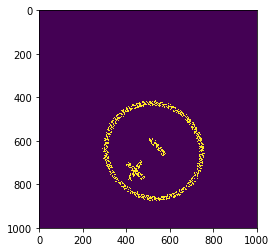

In [1382]:
GRID_SIZE=1000
v = voltage_source_mask(GRID_SIZE//5, None, GRID_SIZE//100, 45, GRID_SIZE, True)
plt.imshow(v)

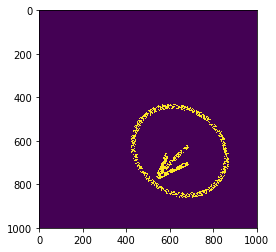

In [1400]:
cs = current_source_mask(GRID_SIZE//5, None, GRID_SIZE//100, 45, GRID_SIZE, True)
plt.imshow(cs)
plt.show()

2632 2582
5214
[[716 957]
 [717 958]
 [717 964]
 ...
 [809 970]
 [810 910]
 [811 872]]
5164


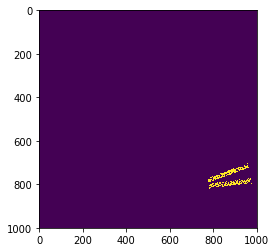

In [1368]:
cap = capacitor(GRID_SIZE//5, None, GRID_SIZE//100, 0, GRID_SIZE, True)
print(np.count_nonzero(cap))
plt.imshow(cap)
plt.show()

['__call__',
 '__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__name__',
 '__ne__',
 '__new__',
 '__qualname__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__self__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__text_signature__']